<a href="https://colab.research.google.com/github/ludlev2/ml_project_cse204/blob/main/Datasets-under-consideration/London/RQ1_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima

In [ ]:
def plot_decomp(timeseries: pd.DataFrame) -> None:
  result = seasonal_decompose(timeseries, model='additive')

  fig = plt.figure()  
  fig = result.plot()  
  fig.set_size_inches(15, 12)


## PREPROCESSING

In [ ]:
df = pd.read_csv('UK_international-visits.csv')

regions = ['North', 'Midlands', 'East', 'South', 'London']
london = ['LONDON']
south = ['SOUTH WEST', 'SOUTH EAST', 'SOUTHERN ENGLAND', ' CHANNEL ISLANDS',  ' ISLE OF MAN']
east = ['EAST OF ENGLAND', 'REST OF ENGLAND']
midlands = ['WEST MIDLANDS', 'EAST MIDLANDS', 'CENTRAL ENGLAND', 'YORKSHIRE']
north = ['NORTH EAST', 'NORTH WEST', ' NORTHERN IRELAND', 'SCOTLAND', 'WALES', "ENGLAND'S NORTH COUNTRY"]

#map regions to areas
df['area'] = df['area'].replace(london, 'London')
df['area'] = df['area'].replace(south, 'South')
df['area'] = df['area'].replace(east, 'East')
df['area'] = df['area'].replace(midlands, 'Midlands')
df['area'] = df['area'].replace(north, 'North')

#drop 'ALL STAYING VISITS' and 'OIL RIGS/TRAVELLING' and 'TOTAL ENGLAND'
df = df[df.area != 'ALL STAYING VISITS']
df = df[df.area != ' OIL RIGS/TRAVELLING']
df = df[df.area != 'TOTAL ENGLAND']

# combine the year and quarter columns
quarters = df['quarter'].unique().astype(str)

#map quarters to end dates
mapping = {
    quarters[0]:'03-31', 
    quarters[1]:'06-30', 
    quarters[2]:'09-30',
    quarters[3]:'12-31'
}
df['quarter'] = df['quarter'].replace(mapping)

#combine year and quarter columns by adding them together, casting them as floats
#map '2019P' to 2019
df['year'] = df['year'].replace('2019P', '2019')
df['year'] = df['year'].astype(str)
df['date'] = (df['year'] + '-' + df['quarter'])

df[['visits', 'date']].groupby('date').sum().to_csv('uk_international_visits_clean.csv')

<ipython-input-71-ff45f1a8857b>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('UK_international-visits.csv')


## INPUT

In [ ]:
 visits = pd.read_csv("uk_international_visits_clean.csv", parse_dates=[0]).set_index('date')
 exog = pd.read_csv("uk_gdp_growth.csv", parse_dates=[0]).set_index('date')

In [ ]:
exog["GDP_Growth_QoQ_1"] = exog["GDP_Growth_QoQ"].shift(1).fillna(method="bfill").values
exog["GDP_Growth_QoQ_2"] = exog["GDP_Growth_QoQ"].shift(2).fillna(method="bfill").values
exog["GDP_Growth_QoQ_3"] = exog["GDP_Growth_QoQ"].shift(3).fillna(method="bfill").values

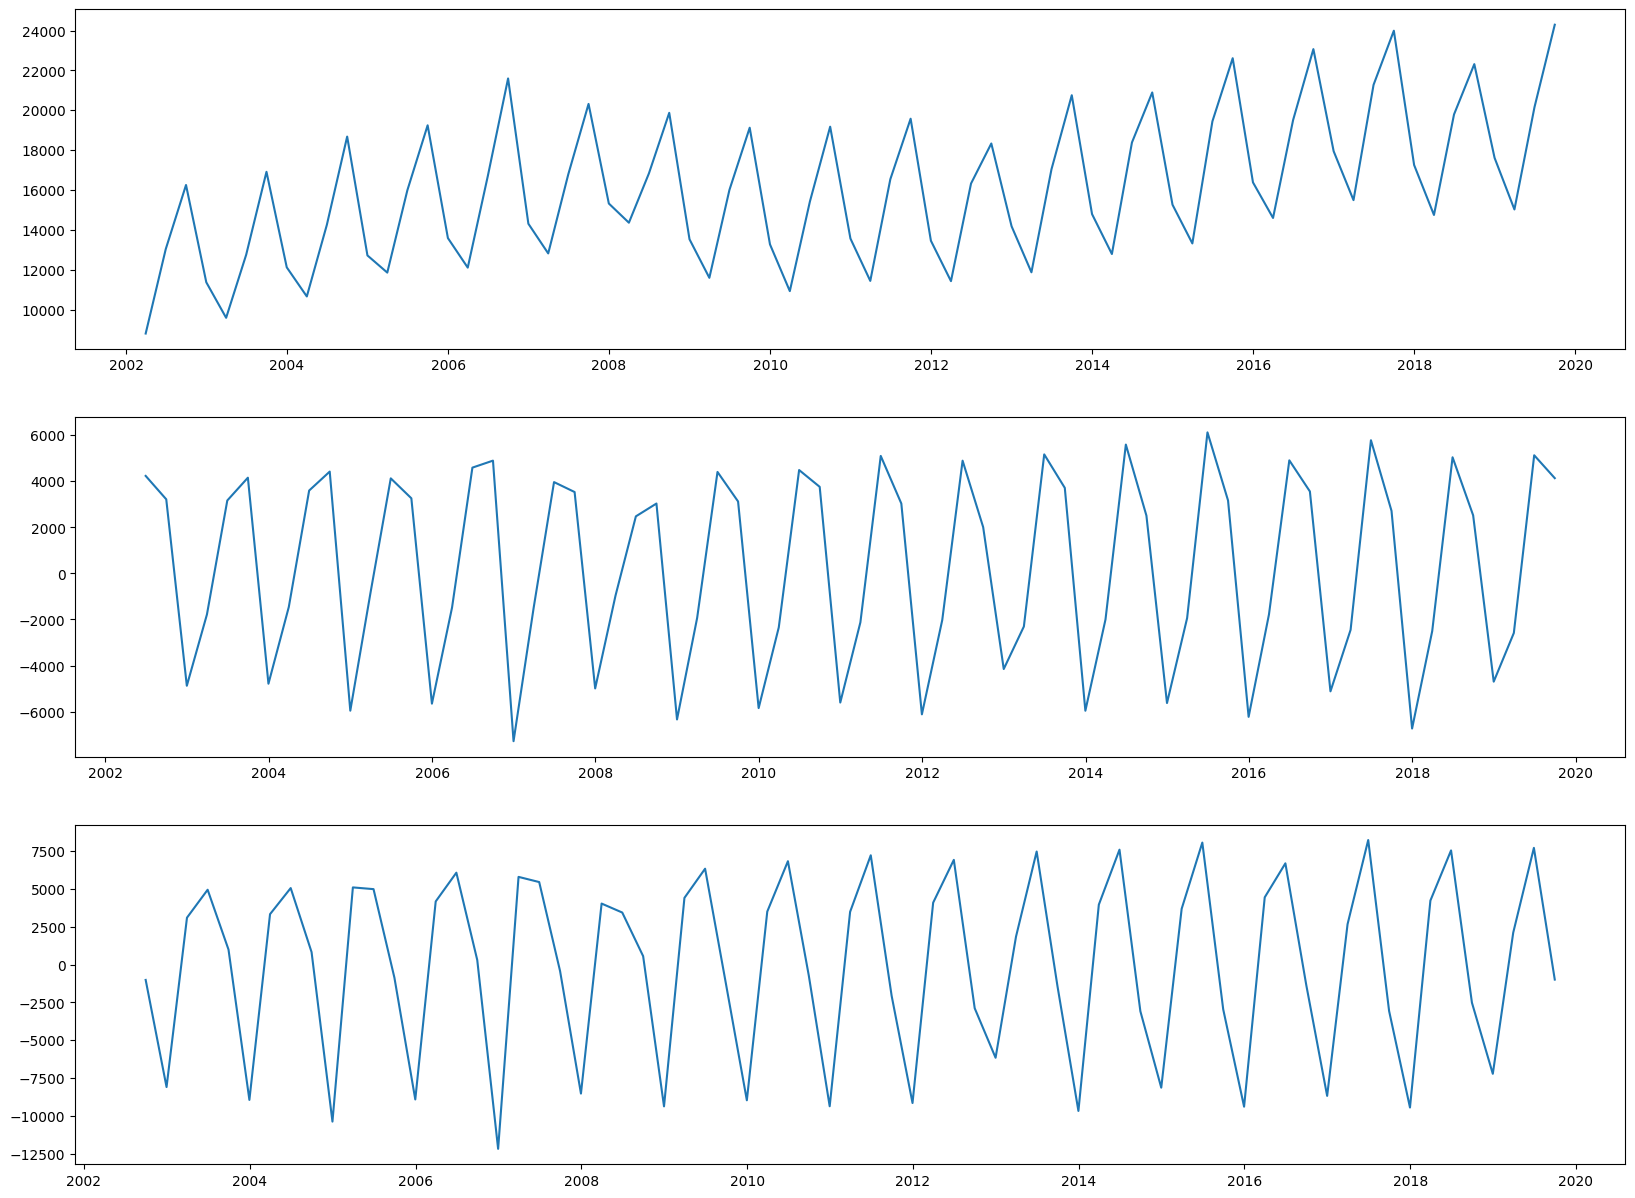

In [ ]:
# We look at the original TS, 1st and 2nd difference to check stationarity
visits_diff_1 = visits.diff().dropna()
visits_diff_2 = visits.diff().diff().dropna()

fig, axs = plt.subplots(nrows=3, figsize=(20, 15))

axs[0].plot(visits)
axs[1].plot(visits_diff_1)
axs[2].plot(visits_diff_2)

## SPLIT

In [ ]:
visits_train = visits[visits.index < datetime(2012, 7, 1)]
visits_test  = visits[visits.index >= datetime(2012, 7, 1)]

exog_train = exog[exog.index < datetime(2012, 7, 1)]
exog_test = exog[exog.index >= datetime(2012, 7, 1)]

## PLOTS and EDA

<Figure size 640x480 with 0 Axes>

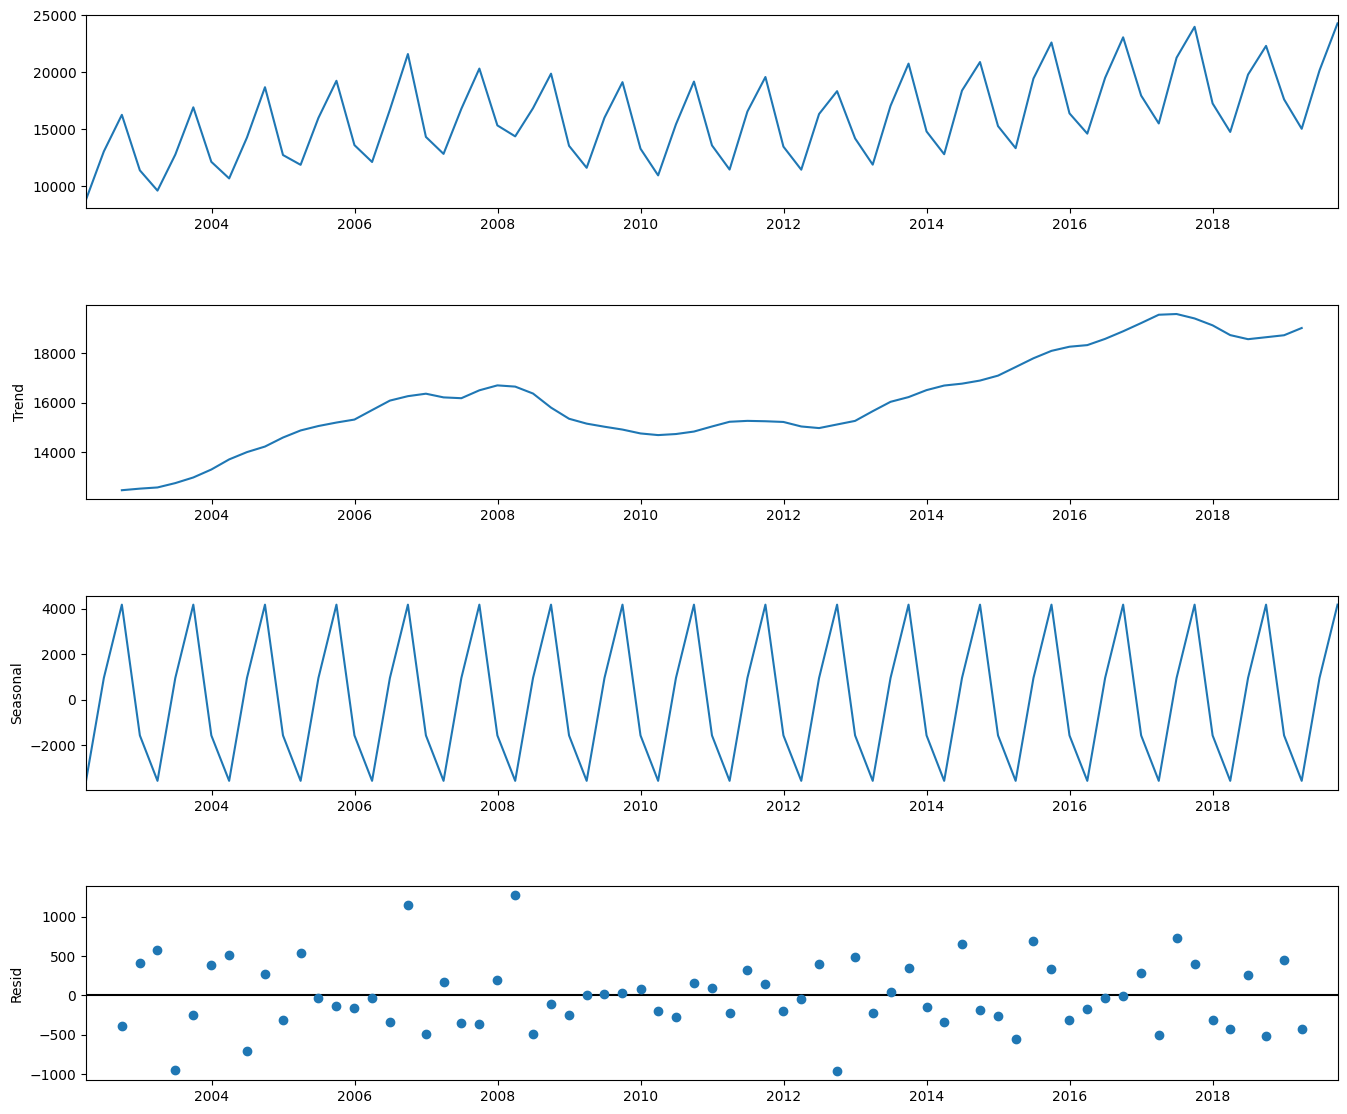

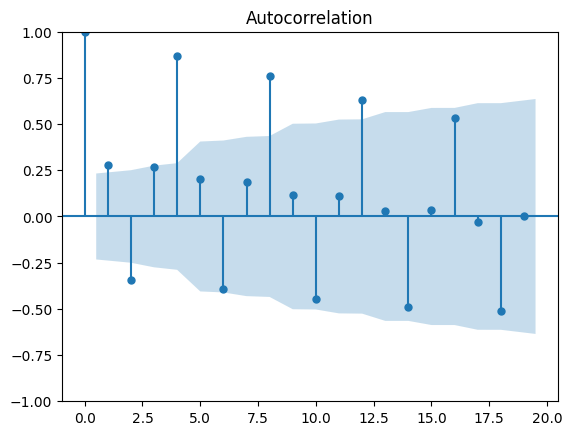

In [ ]:
# Plot decomposition into trend + seasonality + noise, plot acf to check autocorrelation
plot_decomp(visits)
x = plot_acf(visits)

<Figure size 640x480 with 0 Axes>

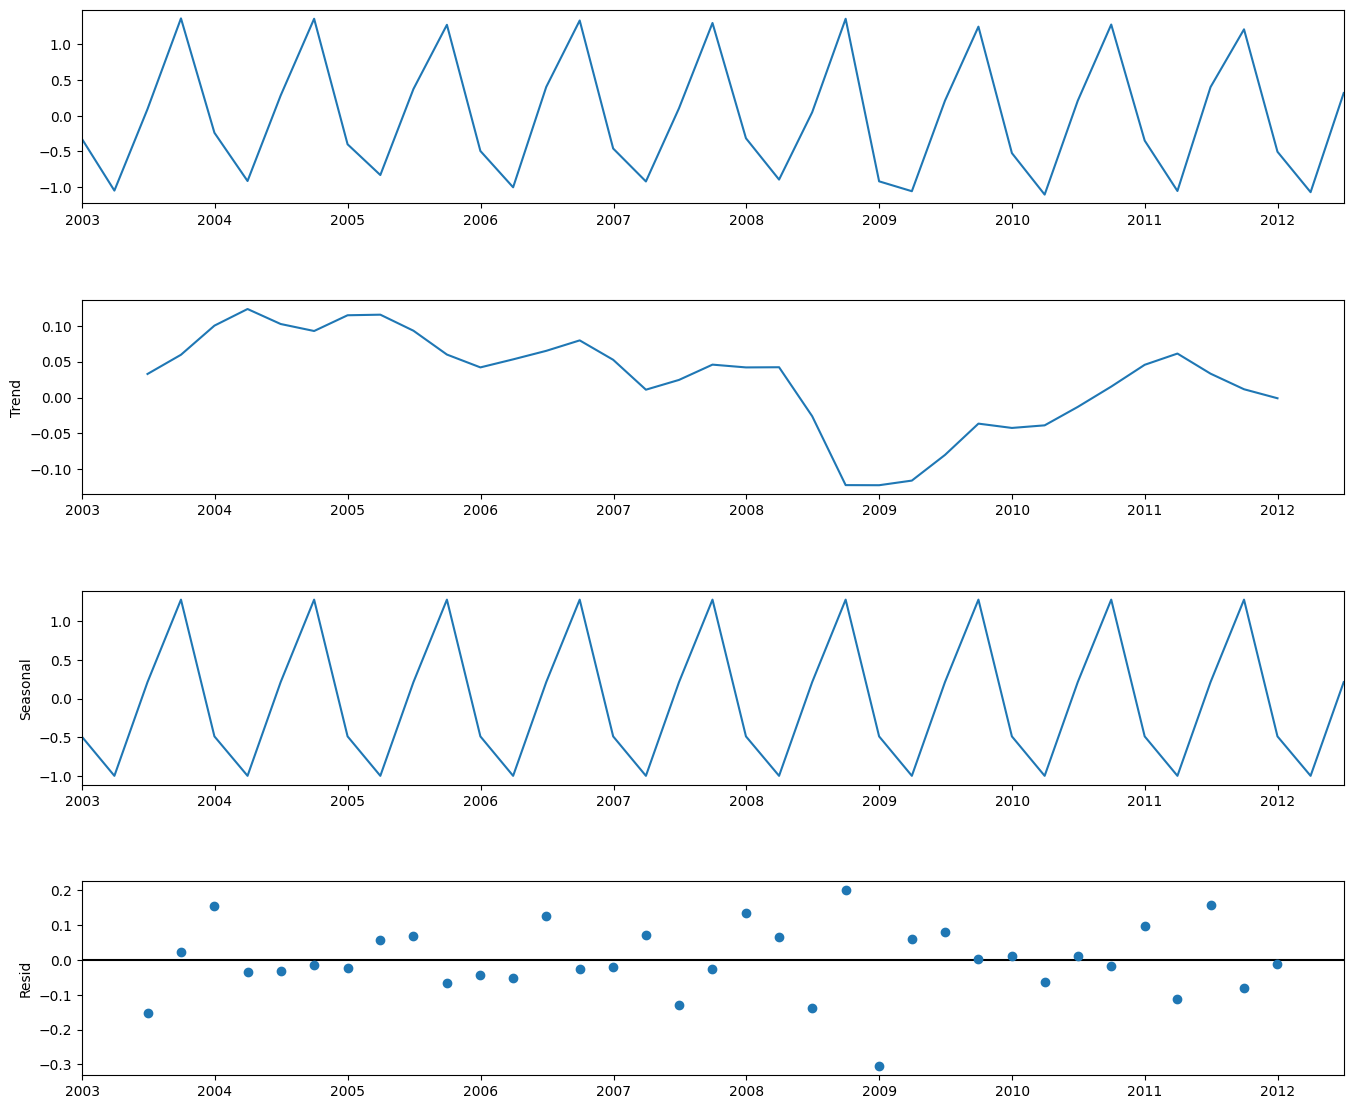

In [ ]:
# Detrend and plot again
visits_detrended = (visits_train - visits_train.rolling(4).mean()) / visits_train.rolling(4).std()
plot_decomp(visits_detrended.dropna())

<Figure size 640x480 with 0 Axes>

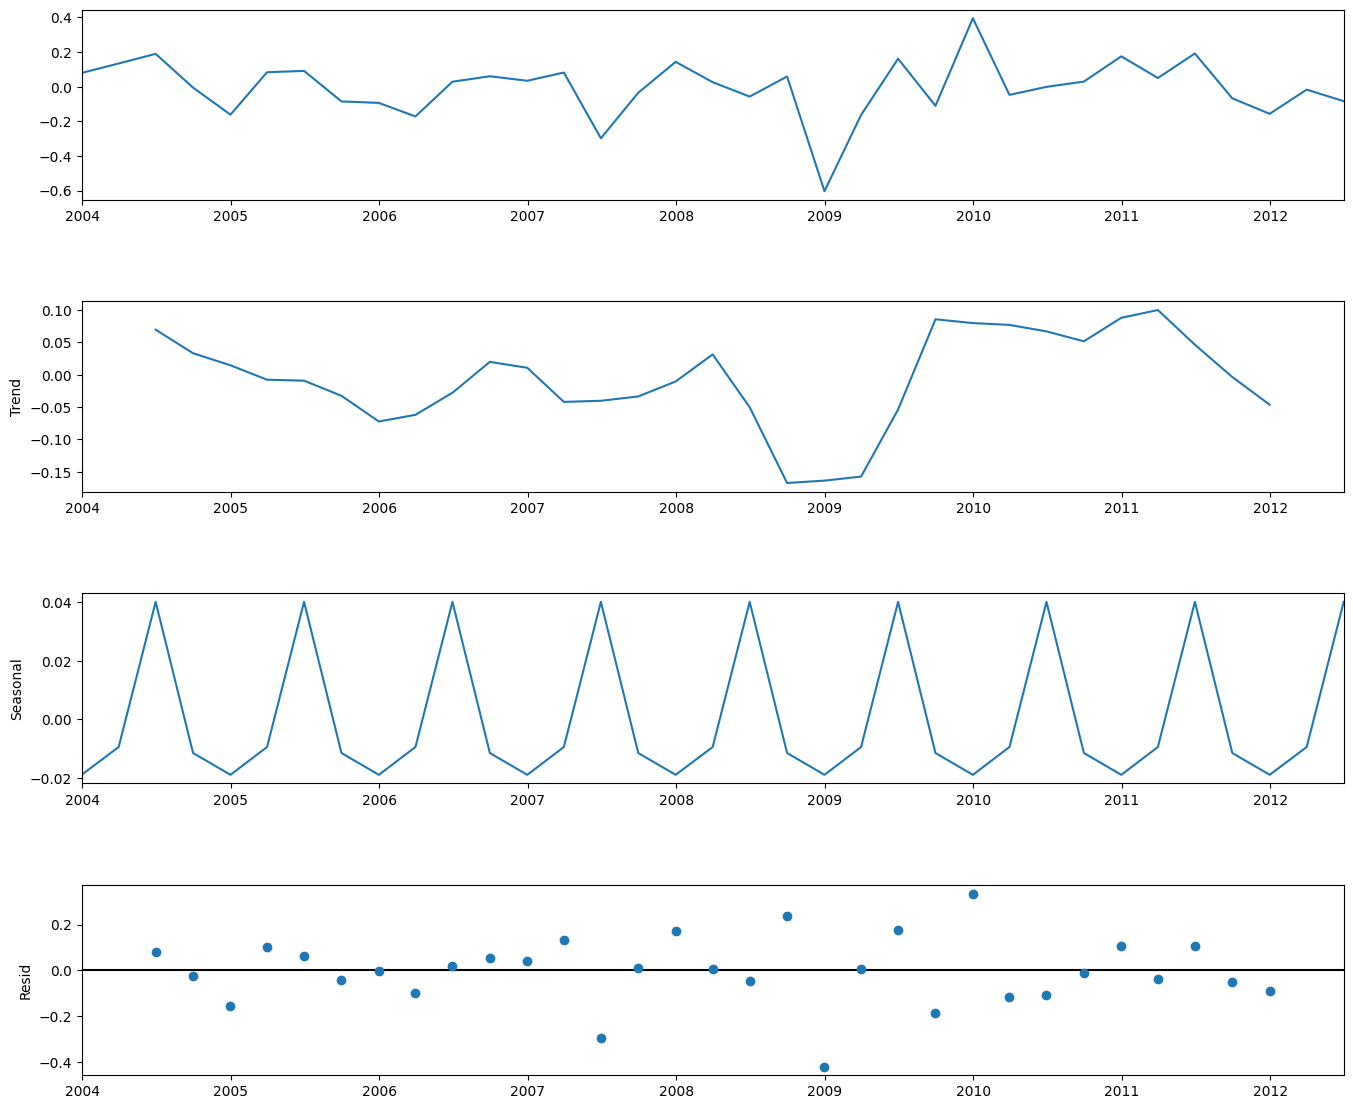

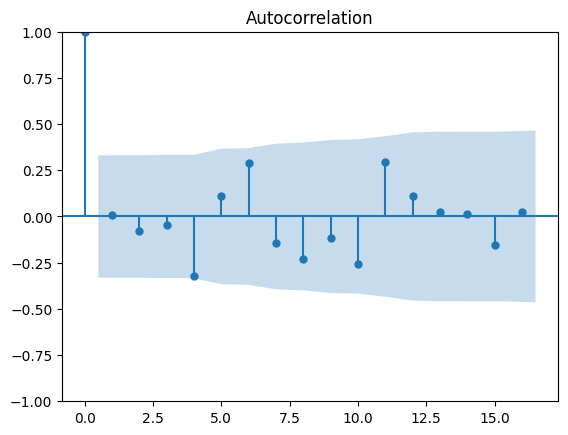

In [ ]:
# Remove seasonality, check acf to ensure it is gone
visits_lagged = (visits_detrended - visits_detrended.shift(4)).dropna()
plot_decomp(visits_lagged)
x = plot_acf(visits_lagged)

In [ ]:
results = {
    'train': adfuller(visits_train['visits']),
    'test': adfuller(visits_test['visits'])
}

for result in results:
  # Extract the test statistic and p-value
  test_statistic = results[result][0]
  p_value = results[result][1]

  # Print the results
  print(f"___{result}___")
  print(f'Test statistic: {test_statistic:.4f}')
  print(f'p-value: {p_value:.4f}')

___train___
Test statistic: -2.7422
p-value: 0.0670
___test___
Test statistic: -1.3295
p-value: 0.6156


In [ ]:
t_statistic, p_value = ttest_ind(visits_train.diff().dropna(), visits_test.diff().dropna())

float(p_value)

0.9777718937556574

## MODELLING

In [ ]:
# automatically select best ARIMA parameters
stepwise_model = auto_arima(
    visits_train, X=exog_train, start_p=1, start_q=1,
    max_p=3, max_q=3, m=4,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=611.000, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=612.221, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=611.626, Time=1.02 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=611.213, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=613.150, Time=0.29 sec
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=613.124, Time=0.89 sec
 ARIMA(1,1,1)(0,1,2)[4]             : AIC=613.124, Time=0.95 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=611.399, Time=0.61 sec
 ARIMA(1,1,1)(1,1,2)[4]             : AIC=614.464, Time=1.20 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=611.214, Time=0.54 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=611.705, Time=0.68 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=611.332, Time=0.53 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=609.759, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=611.748, Time=0.18 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=611.7

In [ ]:
model = ARIMA(
    visits_train, exog=exog_train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)
).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<Axes: >

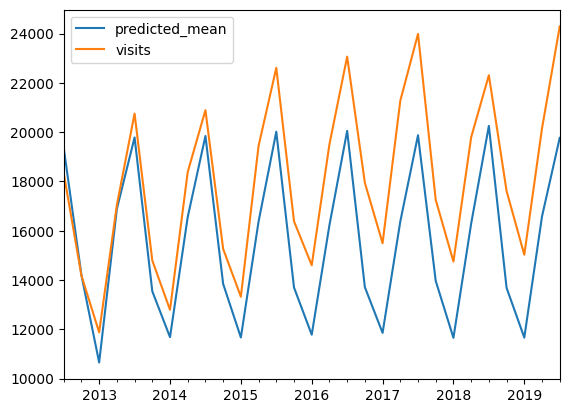

In [295]:
# MAKE A BETTER CHART

pd.concat(
    [
      pd.DataFrame(
          model.predict(start=visits_test.index[0], end=visits_test.index[-1], exog=exog_test)
      ),
      visits_test
    ],
    axis=1
).plot()

<Axes: >

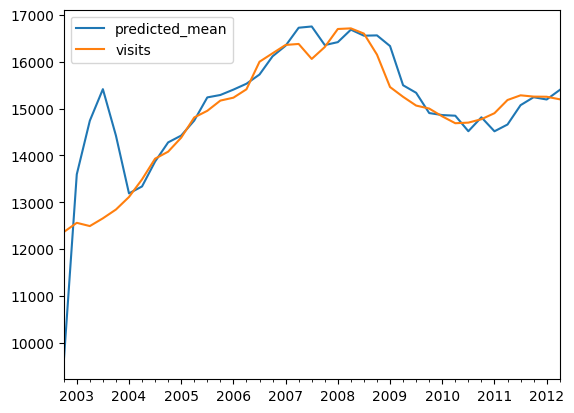

In [ ]:
pd.concat(
    [
      pd.DataFrame(
          model.predict(start=visits_train.index[0], end=visits_train.index[-1], exog=exog_train)
      ).rolling(4).mean().dropna(),
      visits_train.rolling(4).mean().dropna(),
    ],
    axis=1
).plot()

In [296]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            visits   No. Observations:                   42
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                -298.880
Date:                           Sun, 28 May 2023   AIC                            609.759
Time:                                   20:33:24   BIC                            619.425
Sample:                               03-31-2002   HQIC                           613.167
                                    - 06-30-2012                                         
Covariance Type:                             opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
GDP_Growth_QoQ     228.2268    230.329      0.991      0.322    -223.210     679.663
GDP_Growth_QoQ_1   281.7891    283.234      0.995      0.320    -273.339     836.918
GDP_Growth_QoQ_2  -538.3153    235.421     -2.287      0.022    -999.732     -76.898
GDP_Growth_QoQ_3   458.8386    178.322      2.573      0.010     109.334     808.343
ma.S.L4             -0.2738      0.141     -1.942      0.052      -0.550       0.003
sigma2            5.729e+05   1.85e+05      3.097      0.002     2.1e+05    9.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.22   Prob(JB):                         0.42
Heteroskedasticity (H):               1.19   Skew:                            -0.06
Prob(H) (two-sided):                  0.77   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""